Pour info voici mon pipeline de preprocessing. VU que je travaille sur mon laptop j'ai pas énormément de RAM (8g + 8g de swap) donc je suis obligé de découper un peu le travail mais ça permet d'avoir une certaine trace dans les pré-traitements/


In [1]:
name_subj = "S11"

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading raw BDF, setting up bipolar references and montage

In [2]:
raw = mne.io.read_raw_bdf('../../raw_data/%s.bdf'%name_subj,preload=True, verbose=True)

Extracting EDF parameters from /home/gweindel/ownCloud/PhD/Projets/ForceEEG/raw_data/S11.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...


KeyboardInterrupt: 

In [ ]:
mne.set_bipolar_reference(raw,anode=['EXG1','EXG3','EXG5','EXG7'],cathode=['EXG2','EXG4','EXG6','Fp2'],ch_name=['EMG_L','EMG_R','EOGH','EOGV'],copy=False, drop_refs=False) #fixe les références bipolaires pour les électrodes externes
raw.set_channel_types({'EMG_L':'emg','EMG_R':'emg','EOGH':'eog','EOGV':'eog','EXG8':'misc','Erg1':'misc','Erg2':'misc'}) #Détermine les types de canaux 
raw.set_eeg_reference(['EXG8']) #référence eeg  mastoide gauche
raw.drop_channels(['EXG1','EXG3','EXG5','EXG7','EXG2','EXG4','EXG6'])

## Montage

Here I recover the measurment made using ElGuide, however I only use one file (.sfp) from the three generated by subject, but it seems to be OK. (BORIS ?)

In [ ]:
EEGhead_pos = pd.read_csv('../../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=3, sep="\t", index_col=0,header=None,usecols=[0,3,5,7])/1000 #mm scale
ref_pos = pd.read_csv('../../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=0, sep="\t", index_col=0,header=None,usecols=[0,3,6,9],nrows=3)/1000 #mm scale

EEGhead_pos = EEGhead_pos[(np.abs(EEGhead_pos[3]) < (np.std(EEGhead_pos[3])*8))]#removes weird postiion samples larger than 8sd

EEGkeys = EEGhead_pos[:64].index
EEGvalues = np.asarray(EEGhead_pos[:64].reset_index(drop=True))
EEG_points = dict(zip(EEGkeys, EEGvalues))

left, nasion, right = ref_pos.loc["fidt9"].values,ref_pos.loc["fidnz"].values,ref_pos.loc["fidt10"].values #Check LR correctness
head_points = np.asarray(EEGhead_pos[64:].reset_index(drop=True))

dig_montage = mne.channels.make_dig_montage(ch_pos=EEG_points, nasion=nasion, lpa=left, rpa=right, 
                                            hsp=head_points, hpi=None, coord_frame='head')

### Plotting sensor locations

In [ ]:
dig_montage.plot(kind='3d');


In [ ]:
raw.set_montage(dig_montage)
raw.plot_sensors(show_names=True);

# Low-pass filtering

In [ ]:
raw.filter(None, 100, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') #filtre les données entre 0.01 et 100 Hz


## Checking for bad electrodes before applying average referencing

Here I take a first quick look at the data to detect really faulty or flat electrodes, plot not displayed in the notebook I send you because it is not very useful

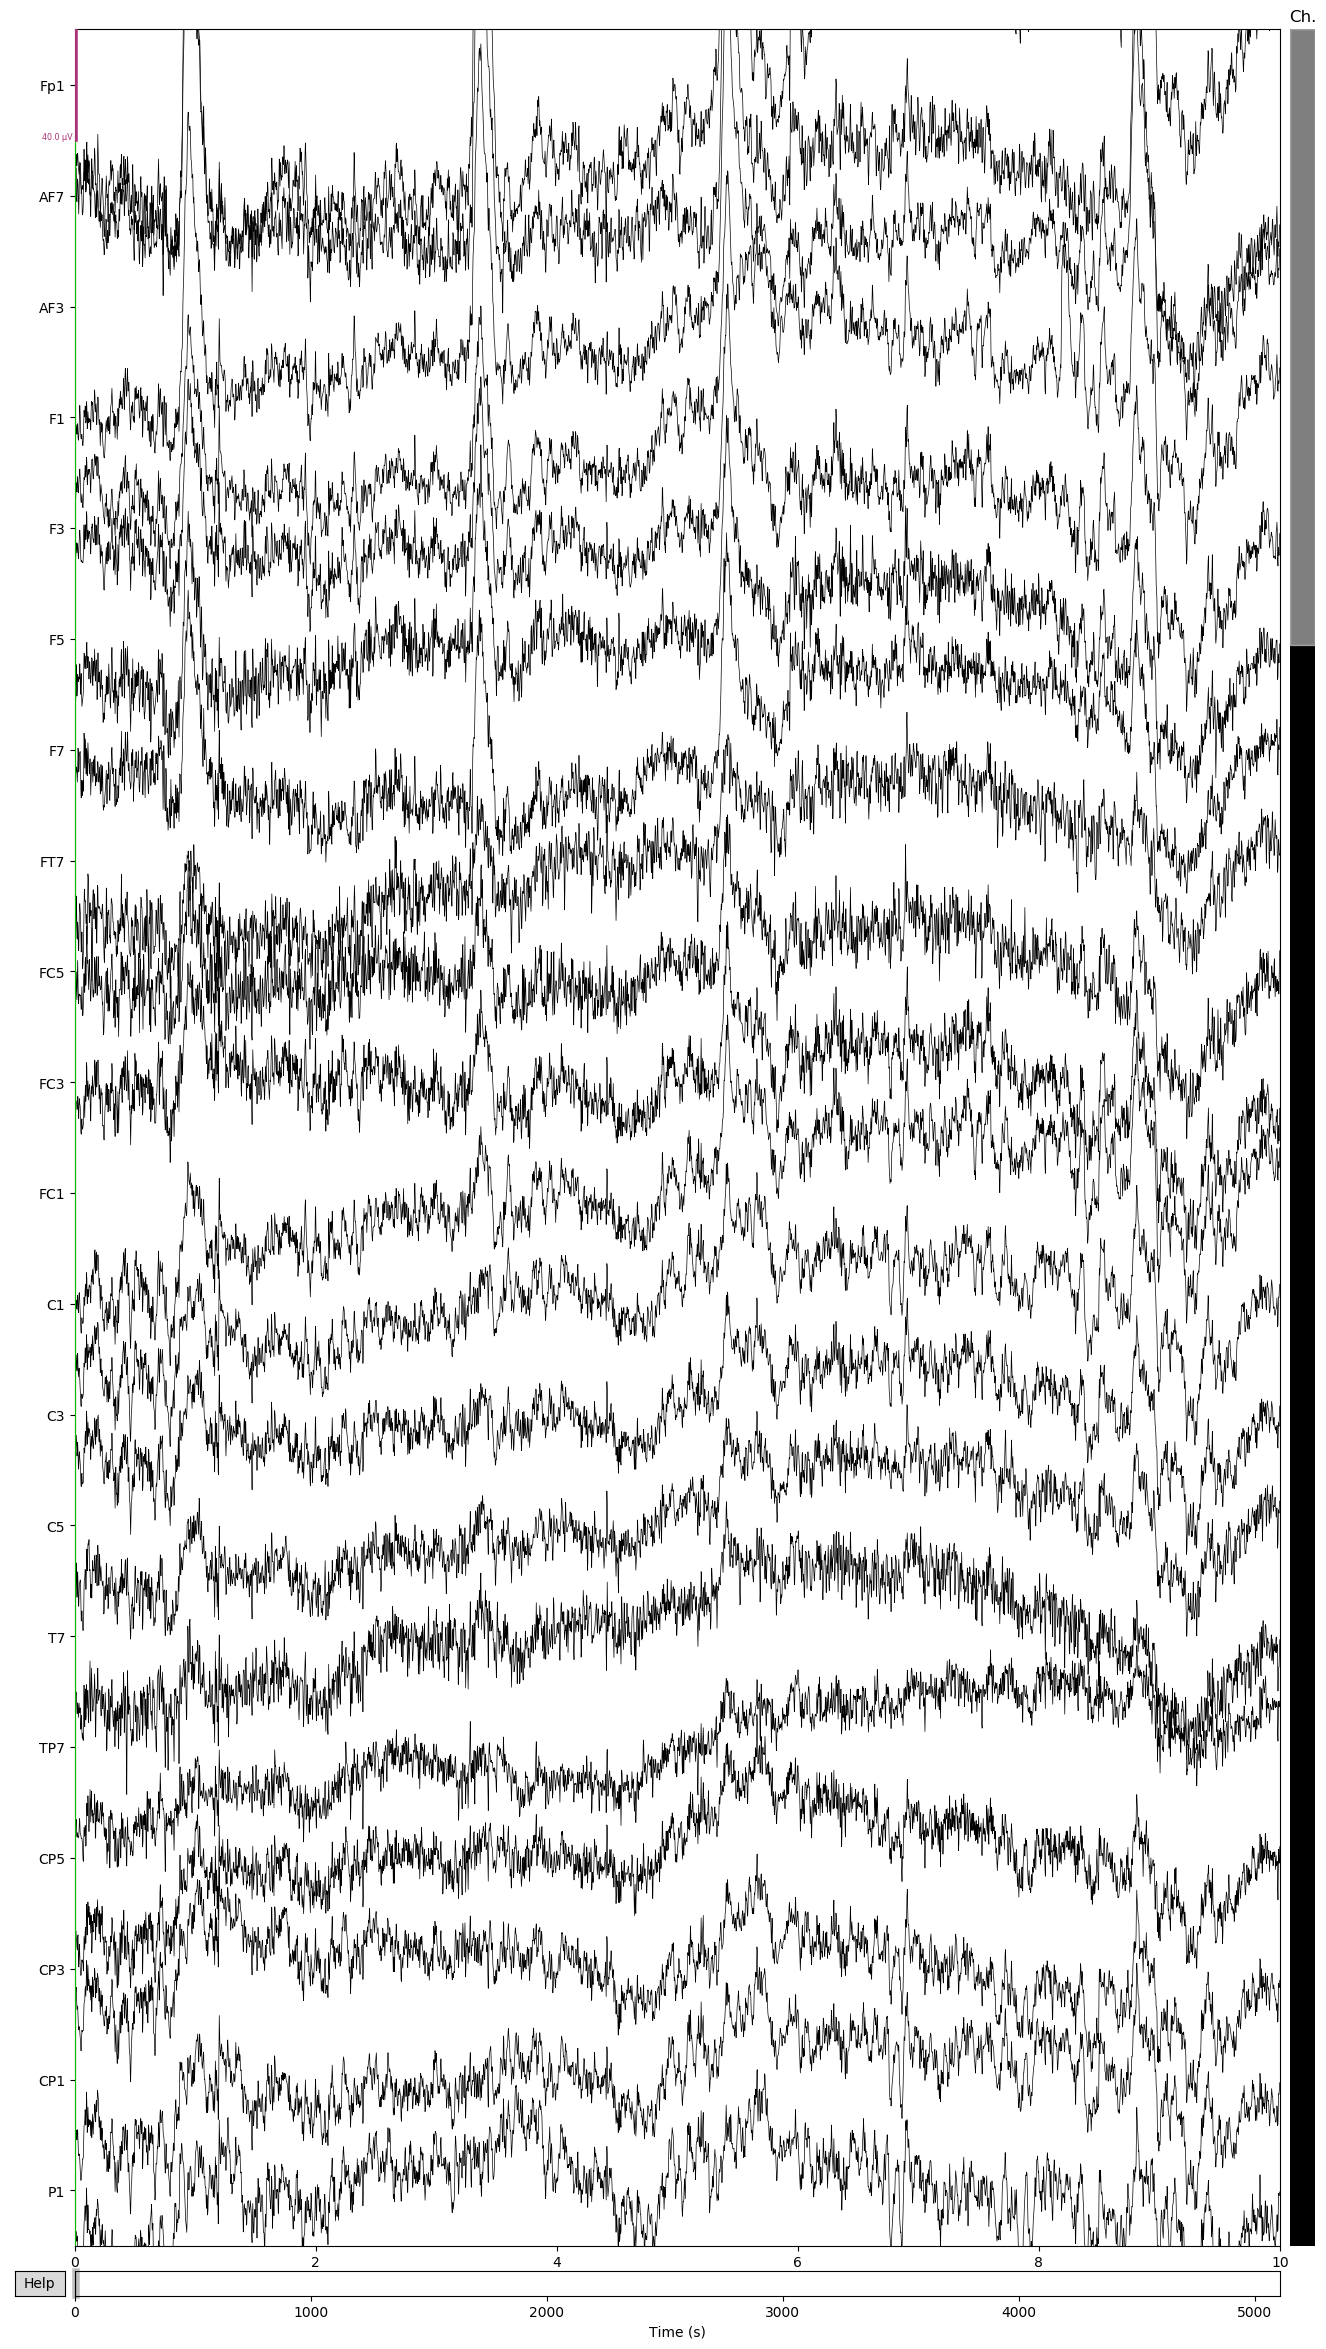

In [10]:
%matplotlib qt
raw.plot()

Notes : 
- RAS

In [11]:
raw.info['bads']

[]

I save the data, hence saving the montage, the low-pass filtered data, the annotation of the bad channel (but none for this subject)

Additionally I re-reference to average as EXG8 is particularly noisy making artifact detection difficult. Plus, simulation studies show that ICA is best achieved using average reference rather than _linked_ mastoids [référence](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6798171/). BTW marking channels as bad before referencing to the average is sufficient to exclude them from the computation of the average

In [12]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<RawEDF | S11.bdf, 72 x 5229568 (5107.0 s), ~2.81 GB, data loaded>

In [14]:
raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_rejection_S11.fif


<ipython-input-14-e39f8df35fab>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_rejection_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_rejection_S11.fif [done]


# Rejecting artefacts

## For the remaining sections and up to the ICA reconstruction I only work with 1Hz High pass filtered data 

The reason being that annotation marked as bad, if not previously filtered to remove slow drifts, gives crazy ICA results (probably because it then captures a lot of edge artifacts from the drifts occuring between the breaks), plus lightly filtered data and average reference seems to ease the detection of artifact, both visually and with the ICA. But the final data (after reconstruction) will remain filtered at 0.01Hz as we usually do and as is recommended for ERP analysis

In [ ]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)

Opening raw data file S11/pre_rejection_S11.fif...


<ipython-input-2-51b23dce2bfc>:1: RuntimeWarning: This filename (S11/pre_rejection_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)


In [ ]:
filt_raw = raw.copy().load_data().filter(l_freq=1., h_freq=None) # I filter to ease processing (and problem with BAD_breaks)

### Recovering events

Code to recover EMG markers and to merge force condition trigger and stim trigger (had to send them separately because of the number of bits and the coding scheme).

In [5]:
original_evts = pd.read_csv('../../processing_EMG/processed/corrected/%s_corrected_evts.csv'%name_subj)
original_evts.code = [int(x) for x in original_evts.code]
original_evts.chan = [int(x) for x in original_evts.chan]
del original_evts["time"]
resp_id = [200, 100]
stim_id = [111,112,113,121,122,123,211,212,213,221,222,223]
force_id = [1,2]
combined_id = [int(str(x[1]) + str(x[0]))  for x in zip(np.tile(stim_id,2), np.repeat(force_id,len(stim_id)))]

emg_chan = [0,1]


evts = original_evts.values

i = 0
max_trials = np.sum(np.isin(evts[:,1], stim_id))
while i < len(evts)-1:
    while evts[i,1] not in force_id and i < len(evts)-1:
        i += 1
    force_trigger = i
    while evts[i,1] not in stim_id and i < len(evts)-1:
        i += 1
    stim_trigger = i
    if i < len(evts)-1:
        evts[stim_trigger, 1] = int(str(evts[force_trigger, 1]) + str(evts[stim_trigger, 1]))
    i += 1
print(np.sum(np.isin(evts[:,1], stim_id)) == 0)
print(np.sum(np.isin(evts[:,1], combined_id)) == max_trials)
original_evts = original_evts.drop(original_evts.iloc[np.isin(evts[:,1], force_id)].index)

True
True


Saving the extracted events

In [6]:
original_evts.to_csv('%s/events_%s.csv'%(name_subj, name_subj))

Total of trials used in the following code

In [7]:
np.sum(np.isin(original_evts.code.values, combined_id))

2448

Correcting the event file to adapt to MNEs events format and keeping only stimuls and response events

In [8]:
evts = original_evts.values
stim_rep_evts = evts[np.isin(evts[:,1], combined_id) | np.isin(evts[:,1], resp_id) ]
stim_rep_evts[:,2] = stim_rep_evts[:,1]

__FYI__ : visualisation of the course of the trials (y= trigger, x=recorded sample) during the experiment for the subject: 

_stimulus trigger_ = XXXX = Force (1:low, 2:High), SAT (1:Accuracy, 2:Speed), expected response (1:left, 2:Right), contrast (1 - 3)

_response trigger_ = 100 (left) 200 (right)

<ipython-input-9-b319de41a708>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(stim_rep_evts);


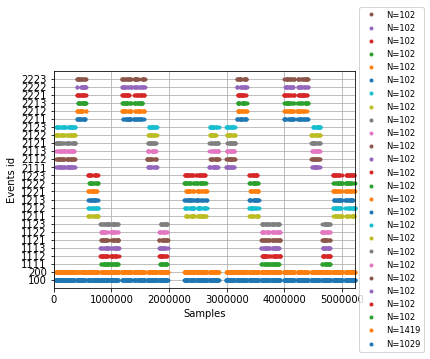

In [9]:
mne.viz.plot_events(stim_rep_evts);

### Detecting and annotating breaks

In the two following cells I mark the period of breaks between the block. I do it because we cannot use these periods in the ICA because they are highly noisy, hence I annotate them and exclude them from the following ICA analysis. I define a break as a duration of more than 10 sec between a response and a stimulus trigger (the duration might be different for other subjects but 10 seconds catches the number of expected breaks)

In [10]:
onset_breaks = stim_rep_evts[np.where(np.diff(stim_rep_evts[:,0], n=1) > (1024*10))][:,0]/1024 #detecting latencies between triggers > 5 sec (searching for the 23 self-paced breaks, and the start of the recording)
offset_breaks = np.flip(np.flip(stim_rep_evts)[np.where(np.diff(np.flip(stim_rep_evts[:,0]), n=1) < -(1024*10))])[:,0]/1024

onset_breaks = onset_breaks + 1 #add 1 sec after last response trigger
offset_breaks = offset_breaks - 1 #removes 1 sec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_rep_evts[-1,0]/1024+1)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_rep_evts[0,0]/1024-1)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks



duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))

25


25 breaks = 23 self paced breaks + beginning of recording + end of recording

In [11]:
break_annot = mne.Annotations(onset= onset_breaks,
                           duration= duration_breaks,
                           description=['BAD_breaks'])
filt_raw.set_annotations(break_annot)

<Raw | pre_rejection_S11.fif, 72 x 5229568 (5107.0 s), ~2.81 GB, data loaded>

## visual artifact rejection

event trigger color code

In [12]:
color_dict = {k:'b' for k in combined_id}
color_dict.update({100:'r', 200:'r'})

Channel order (as we are mainly interesetd with visual latencies I plot the channels from posterior to anterior)

In [13]:
channels = dict(zip(raw.ch_names, np.arange(len(raw.ch_names))))

ch_order= [70,71, 65,66, 27,63,28,26,61,62,29,24,25,60,59,58,57,56,30,19,20,21,22,23,\
           52,53,54,55,31,18,17,16,15,51,50,49,48,47,11,12,13,14,42,43,44,45,46,\
           10,9,8,7,41,40,39,38,37,3,4,5,6,34,35,36,2,1,33,32,0]


### Visualisation window

Brief summary of my artifact rejection philosophy : - 
- Rejecting very rare artifacts present on ROI (mainly visual and motor cortices) in the timing of interest (a bit before stim to a bit after rep)
- I mark when blinks/saccades are during stim presentation as information is delayed/biased (I therefore also display EOG)
- Rejecting rare high variance artifacts (e.g. EMG on all channels) to avoid that these obvious artifact be picked by the ICA
- Keeping recurrent artifacts likely to get picked up by artifact 

So in few words : avoid biasing ERPs and ease the following ICA, mark as less as possible because I want to reject epochs with ICA survival artifacts after all the preprocessing

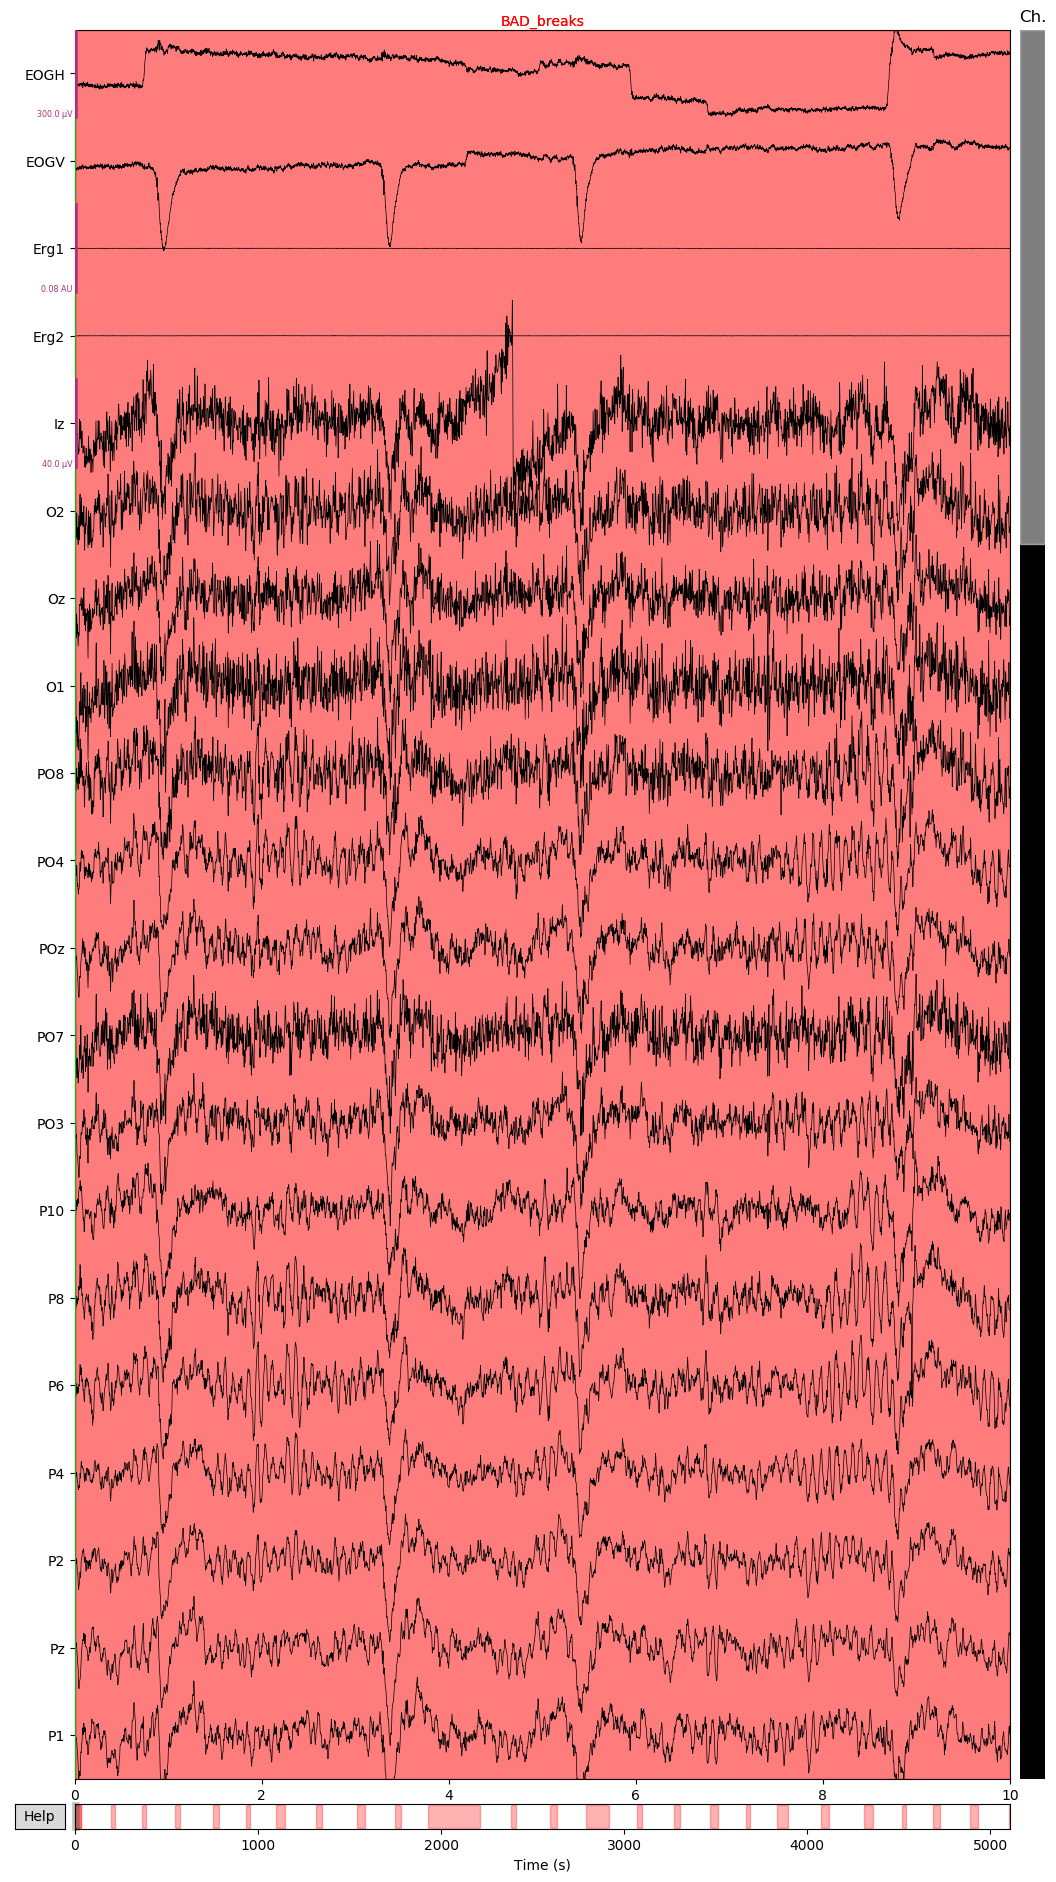

In [14]:
%matplotlib qt

filt_raw.plot(events=stim_rep_evts, event_color=color_dict, remove_dc=True, order=ch_order)

Notes based on raw inspection : 
- IZ high noise probably loose, should be interpolated... Seems present only on the 2 or 3 fist blocks
- Same for Oz and O1 but present in later trial often after response
- O2 has blink like activity
- Regular EMG artifact on F7, F5, F3 abd  FT7, FC5, FC3, marked only if close to response, no need to remove in ICA

Number of annotation + saving

In [15]:
filt_raw.annotations

<Annotations | 115 segments: BAD_ (89), BAD_breaks (26)>

In [16]:
filt_raw.annotations.save('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
#annot_from_file = mne.read_annotations('saved-annotations.csv')
#print(annot_from_file)

Saving the (high-pass filtered) data with the annotations for breaks and artifact

In [17]:
filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_ica_S11.fif


<ipython-input-17-b5f5a09c0b2f>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_ica_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessing/S11/pre_ica_S11.fif [done]


# Fitting ICA

In [2]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

Opening raw data file S11/pre_ica_S11.fif...


<ipython-input-2-a412b60167ca>:1: RuntimeWarning: This filename (S11/pre_ica_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 5229567 =      0.000 ...  5106.999 secs
Ready.
Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...


clevo = 1156.3s.

In [3]:
ica = mne.preprocessing.ICA(max_pca_components = 64-len(filt_raw.info["bads"])-1) #-1 because better when average reference is used (rank)
ica.fit(filt_raw.crop(tmax=filt_raw.times.max()-500), reject_by_annotation=True, decim=2)
        #I use decim=2 to downsample to 512Hz because ICA eats up a lot of RAM For this subjct I also crop the 1000 last seconds for that reason

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 1308118 of 4717568 (27.73%) samples, retaining 3409450 (72.27%) samples.
Selecting all PCA components: 63 components


/home/gweindel/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Fitting ICA took 905.3s.


<ICA  |  raw data decomposition, fit (fastica): 1704725 samples, 63 components, channels used: "eeg">

In [4]:
ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Writing ICA solution to S11/ICA_object_S11.fif...


<ipython-input-4-999a4b462724>:1: RuntimeWarning: This filename (S11/ICA_object_S11.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))


<ICA  |  raw data decomposition, fit (fastica): 1704725 samples, 63 components, channels used: "eeg">

# Inspecting ICA

__Nota Bene__ : I fitted the ICA on the filtered continuous data, however I want to know how the ICA cleaned the epoched data, hence I inspect the ICA components mainly on the epoched data from the raw data (no low-pass filter other than the one used by biosemi, 0.01 Hz right ?)

In [2]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)

Opening raw data file S11/pre_rejection_S11.fif...


<ipython-input-2-51b23dce2bfc>:1: RuntimeWarning: This filename (S11/pre_rejection_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)


    Range : 0 ... 5229567 =      0.000 ...  5106.999 secs
Ready.


In [3]:
annot_from_file = mne.read_annotations('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
raw.set_annotations(annot_from_file)
print(raw.annotations)

<Annotations | 115 segments: BAD_ (89), BAD_breaks (26)>


In [4]:
ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Reading S11/ICA_object_S11.fif ...
Now restoring ICA solution ...


<ipython-input-4-c4cd4f34906e>:1: RuntimeWarning: This filename (S11/ICA_object_S11.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))


Ready.


### Visualizing on epochs

In [5]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

epochs_ica = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.5, tmax=1, preload=True)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2448 events and 1537 original time points ...
199 bad epochs dropped


In [6]:
epochs_ica.resample(500)

<Epochs  |   2249 events (all good), -0.5 - 0.998 sec, baseline [None, 0], ~927.1 MB, data loaded,
 'high/accuracy/left/1': 87
 'high/accuracy/left/2': 84
 'high/accuracy/left/3': 89
 'high/accuracy/right/1': 83
 'high/accuracy/right/2': 84
 'high/speed/accuracy/3': 85
 'high/speed/left/1': 98
 'high/speed/left/2': 96
 'high/speed/left/3': 97
 'high/speed/right/1': 100
 'high/speed/right/2': 100
 'high/speed/right/3': 97
 'low/accuracy/left/1': 96
 'low/accuracy/left/2': 96
 'low/accuracy/left/3': 98
 'low/accuracy/right/1': 95
 'low/accuracy/right/2': 97
 'low/speed/accuracy/3': 96
 'low/speed/left/1': 94
 'low/speed/left/2': 98
 'low/speed/left/3': 96
 'low/speed/right/1': 89
 'low/speed/right/2': 99
 'low/speed/right/3': 95>

### ICs epoch timecourse


In [7]:
%matplotlib qt
ica.plot_sources(epochs_ica);

__Nota Bene__ : epochs are dropped if artifact is in the epoch window

Notes from epoch time course of the ICs : 
- Eyes : 0, 10
- EMG : 5, 15,38, 42, 43, 44, 49, 51, 53, 57
- Suspicous : 6, 20, 26, 28, 34, 52, 60

### ICs topomap

In [8]:
ica.plot_components();

Notes on ICs based on topomap  : 
- Blinks : 0
- Suspicious : 1,23
- saccades/face EMG : 3, 14,16,21,22,47,48,50,51
- TP EMG :  15,42,43,57
- channel noise : 10, 26, 28,30,59


In [5]:
comp_to_inspect = np.array([0,1,23,3, 14,16,21,22,47,48,50,51,15,42,43,57,10, 26, 28,30,59,0, 10,5, 15,38, 42, 43, 44, 49, 51, 53, 57,6, 20, 26, 28, 34, 52, 60])
comp_to_inspect = np.sort(np.unique(comp_to_inspect))
print(comp_to_inspect)

[ 0  1  3  5  6 10 14 15 16 20 21 22 23 26 28 30 34 38 42 43 44 47 48 49
 50 51 52 53 57 59 60]


## Individual ICs inspection

During the next lines I inspect each EOG, EMG or suspicious IC and decide, after the plots of each category, wether to KEEP or to REJECT the IC

### EOG : Checking against recorded EOG (horizontal and vertical)

This section looks at the covariation between the recorded EOG (horizontal and vertical) and the extracted ICs to find those ICs that likely contains eyes artifacts

In [10]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

eog_indices, eog_scores = ica.find_bads_eog(filt_raw.resample(500))
ica.exclude = eog_indices

Opening raw data file S11/pre_ica_S11.fif...


<ipython-input-10-af9efacd6f55>:1: RuntimeWarning: This filename (S11/pre_ica_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 5229567 =      0.000 ...  5106.999 secs
Ready.
Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...
Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7628 events found
Event IDs: [  1   2 100 111 112 113 121 122 123 200 211 212 213 221 222 223 256 512
 768 769 770 868 879 880 881 889 890 891 968 979 980 981 989 990 991]
Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7607 events found
Event IDs: [  1   2 100 111 112 113 121 122 123 200 211 212 213 221 222 223 256 512
 768 769 770 868 879 880 881 889 890 891 968 979 980 981 989 990 991]
Omitting 692705 of 2553500 (27.13%) samples, retaining 1860795 (72.87%) samples.
Omitting 692705 of 2553500 (27.13%) samples, retaining 1860795 (72.87%) samples.


<ipython-input-10-af9efacd6f55>:3: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  eog_indices, eog_scores = ica.find_bads_eog(filt_raw.resample(500))


Omitting 692705 of 2553500 (27.13%) samples, retaining 1860795 (72.87%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 8192 samples (16.384 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transiti

Now I plot the scores, namely the "covariance" between HEOG (top panel), VEOG (lower panel) and the ICs (x axis)

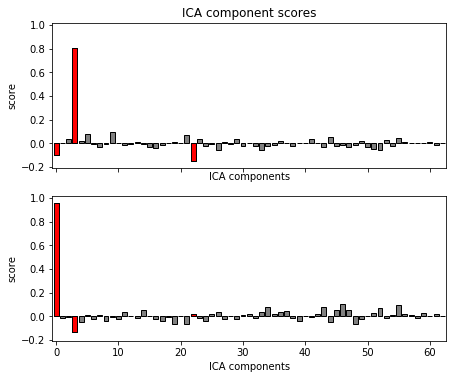

In [11]:
%matplotlib inline 
ica.plot_scores(eog_scores);

MNE's algorithm extracted automatically the following ICs :

In [12]:
eog_indices

[0, 3, 22]

Now I plot for each of these components the topomap; the activity for the created epochs around the stimulus (presentation of the stimuls at 0.2 sec); the spectrum, and the variance of the IC measured at each epoch (watch out the y-axis of this last plot varies a lot across ICs)

In [7]:
inspected_comp = np.array([0,3,22])

    Using multitaper spectrum estimation with 7 DPSS windows
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


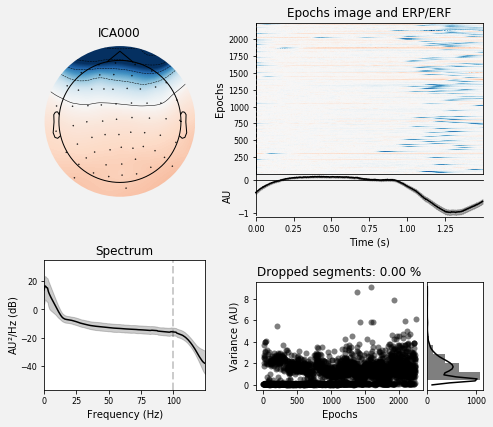

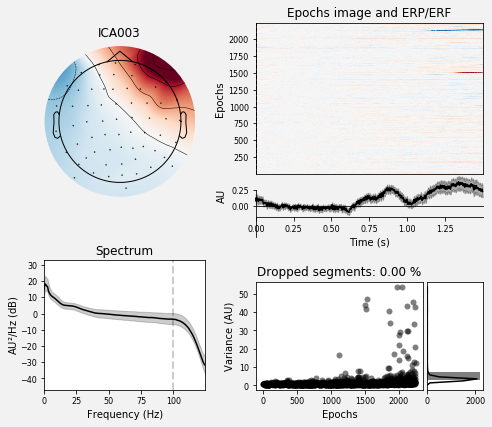

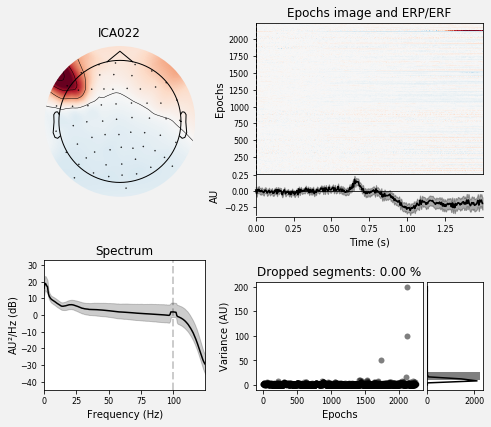

In [14]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

#### Interpretation of the EOG ICs
- ICA 0 contains blinks REJECT
- 3,22 = Saccades REJECT


In [8]:
ica.exclude = []
eog_comp = [0,3,22]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

### EMG components

#### Suspected EMG activity from the face

from the notes above the general plot of the ICs (time course and topomap) I look at 6, 12, 20 (already studied above), 25, 33, 36, 39

In [9]:
inspected_comp = np.array([3, 14,16,21,22,47,48,50,51])

    Using multitaper spectrum estimation with 7 DPSS windows
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseli

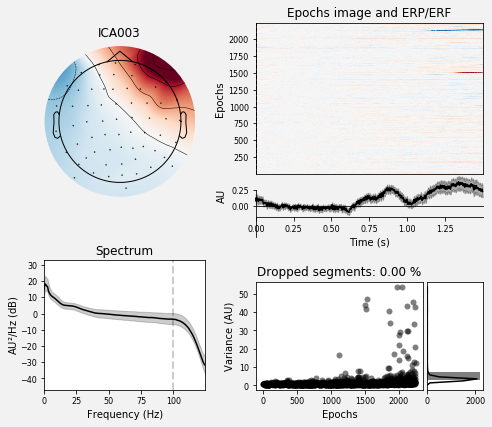

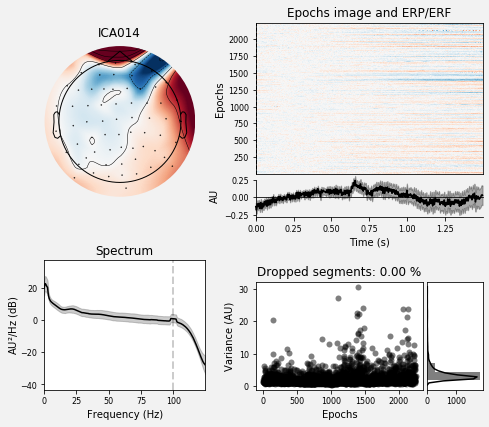

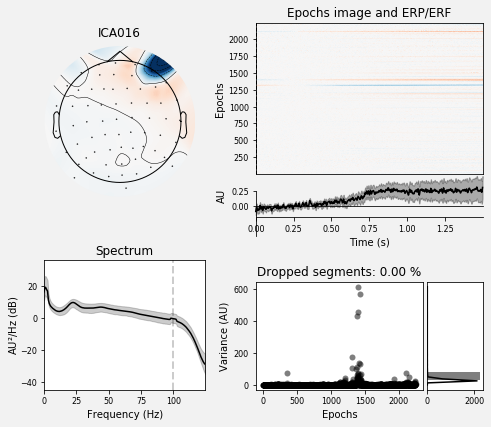

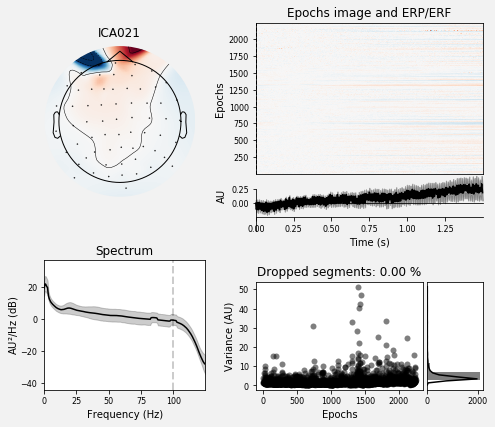

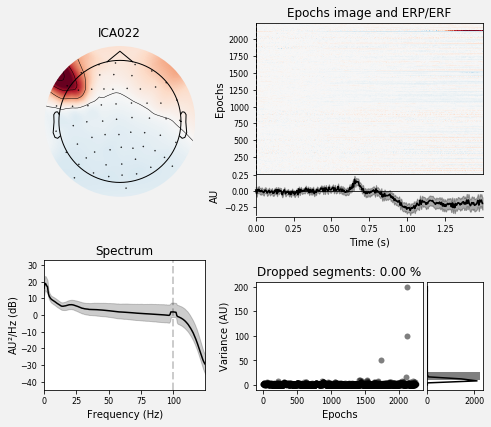

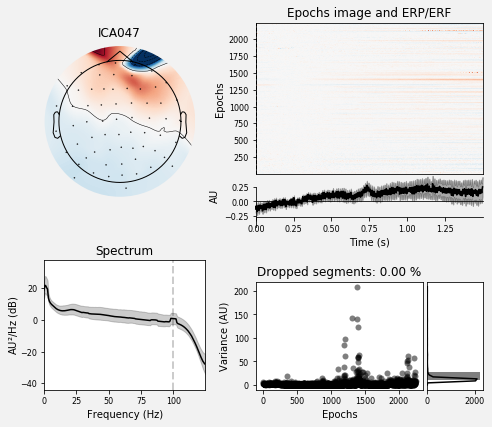

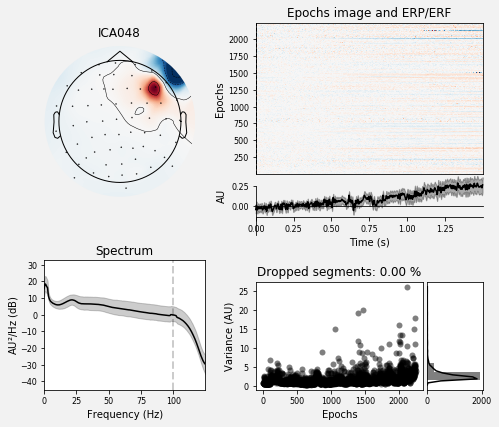

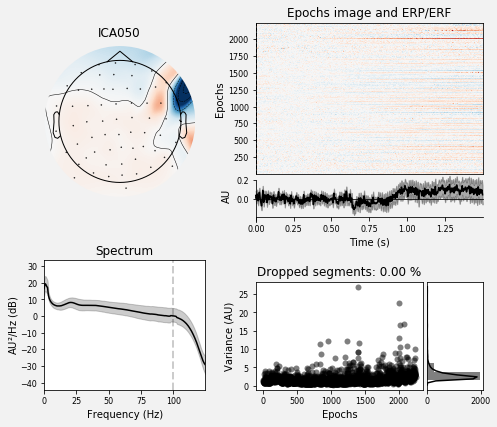

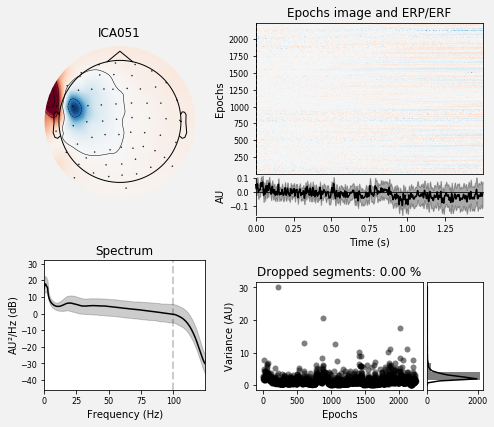

In [17]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

- ICA 3,14,16,21,22,47,48,50,51 : linked to face EMG without doubt, REJECT

In [10]:
face_emg_comp = [3,14,16,21,22,47,48,50,51]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

#### Other suspected EMGs

In [12]:
inspected_comp = np.array([15,42,43,57])

    Using multitaper spectrum estimation with 7 DPSS windows
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


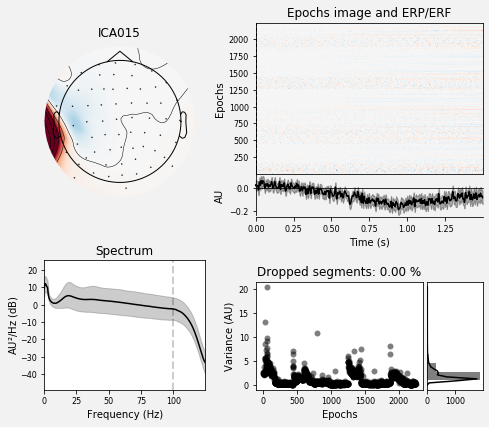

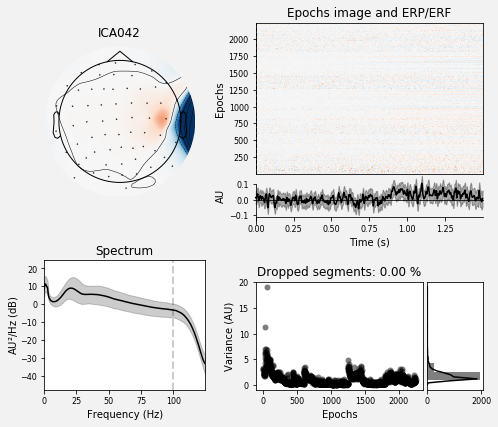

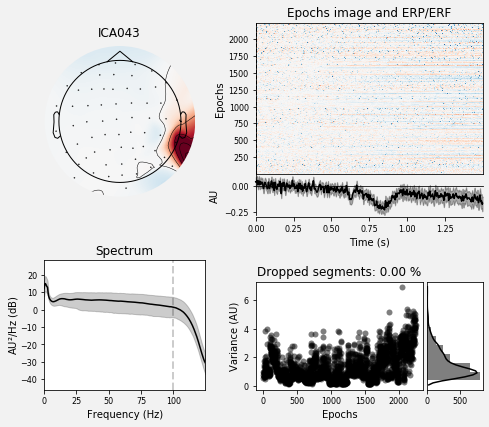

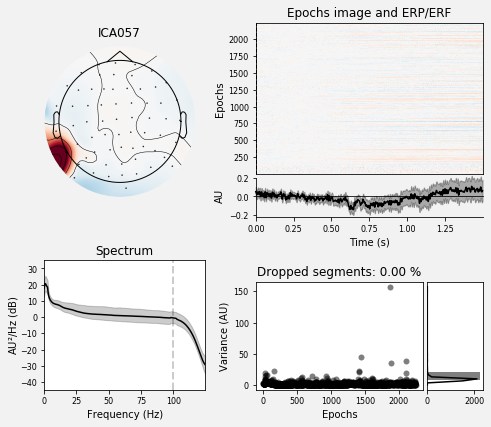

In [21]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

- ICA 15,42,43 : TP EMG, high variance REJECT
- IC 57 : unclear spectrum, only high in few epochs KEEP


In [13]:
other_emg_comp = [15,42,43]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

## Other strange components

In [14]:
print(comp_to_inspect)

[ 1  5  6 10 20 23 26 28 30 34 38 44 49 52 53 59 60]


    Using multitaper spectrum estimation with 7 DPSS windows
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2249 matching events found
No baseli

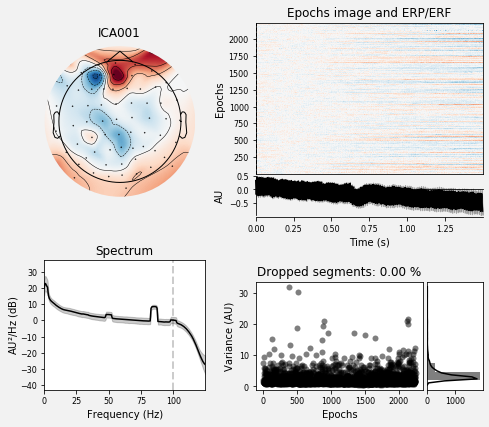

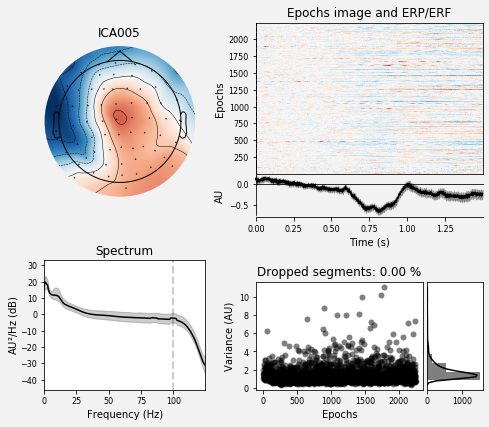

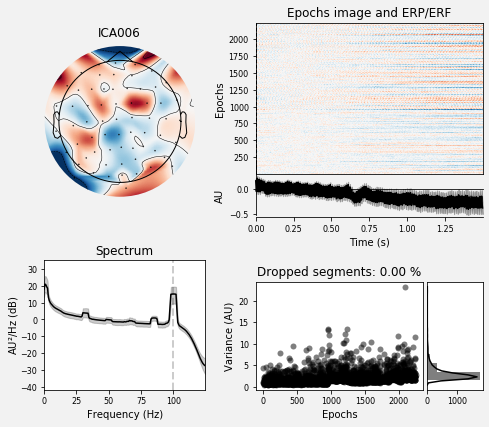

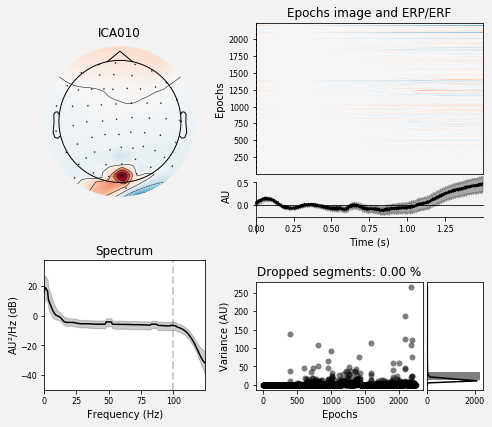

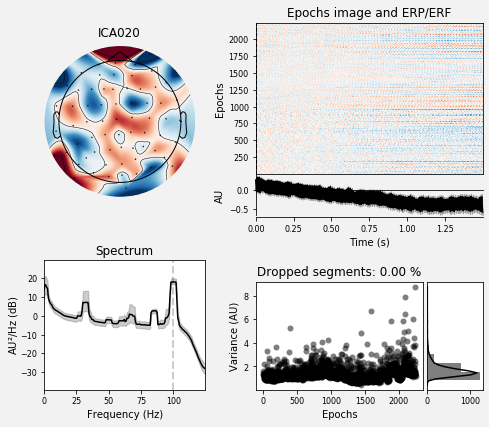

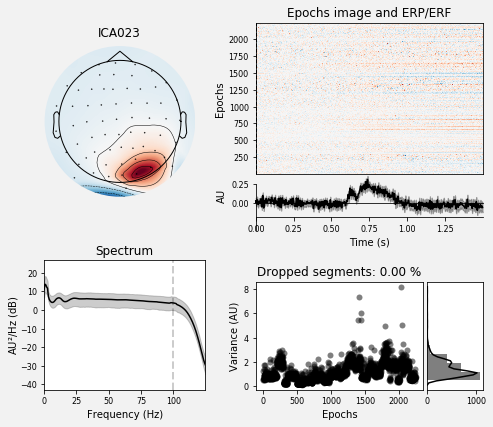

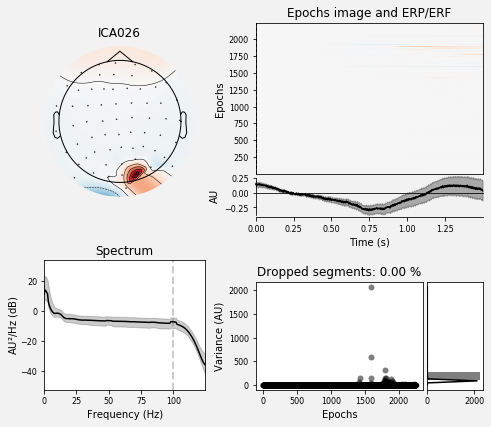

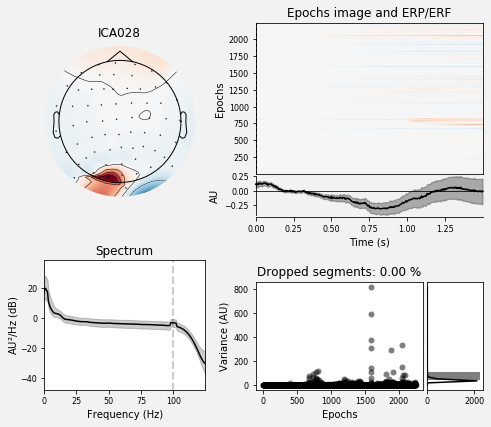

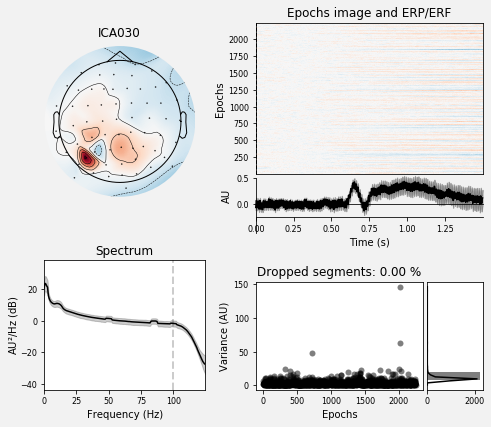

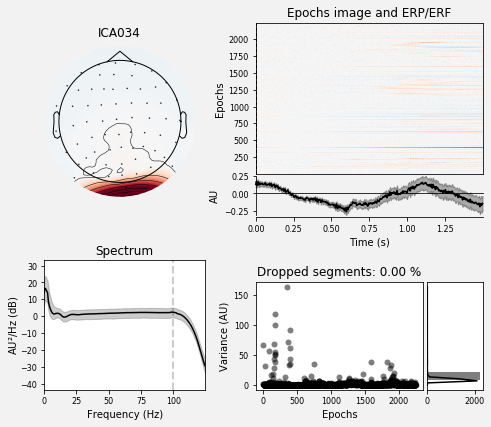

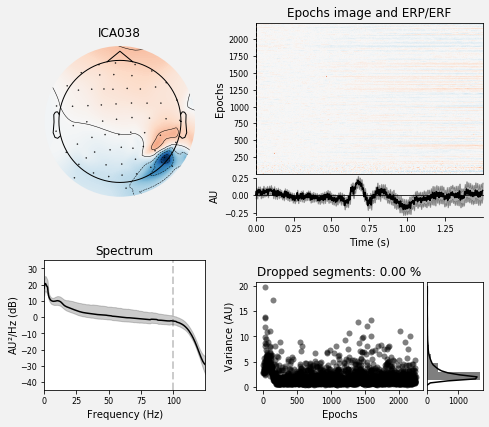

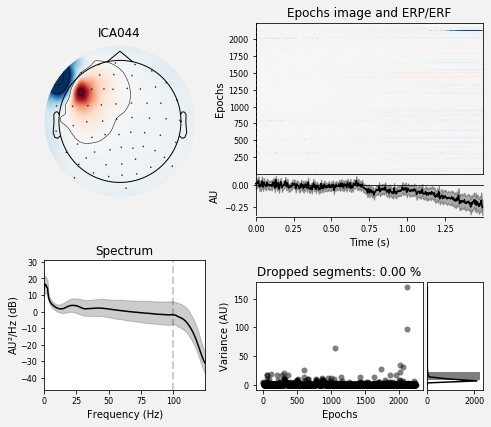

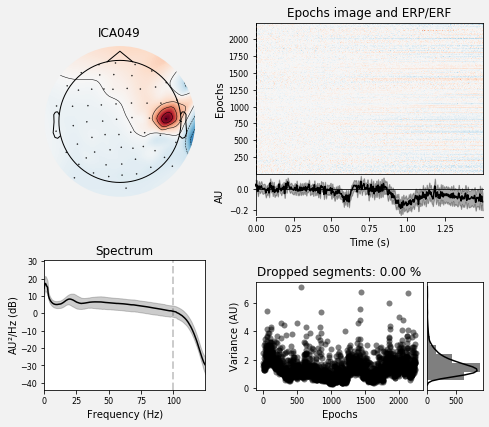

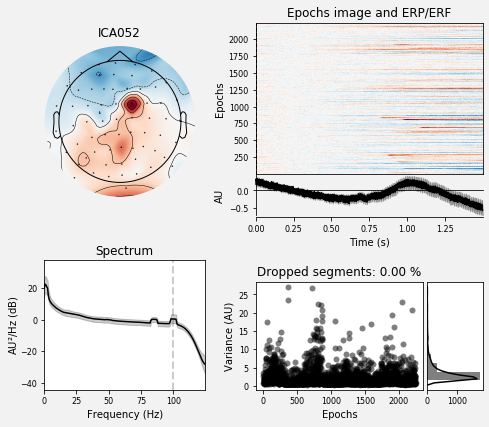

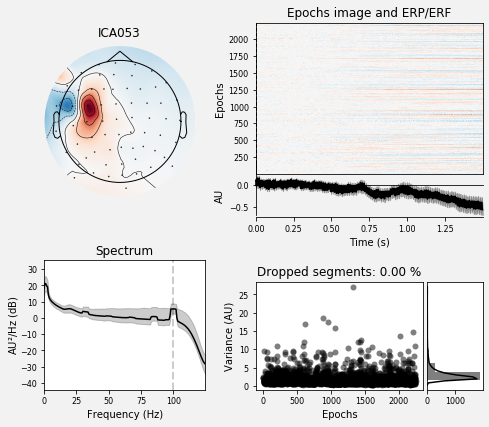

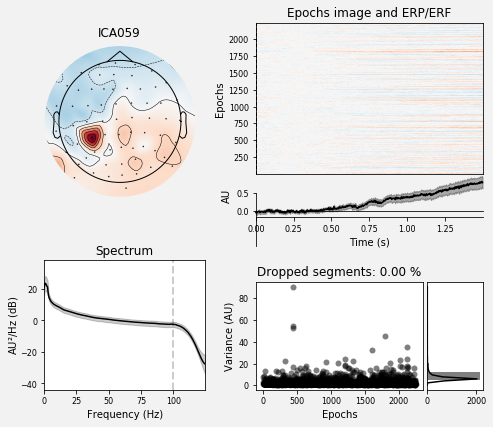

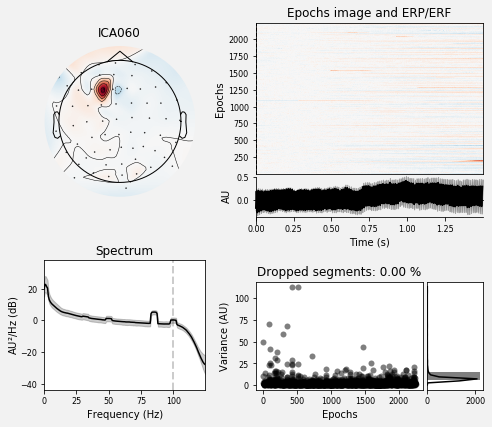

In [24]:
ica.plot_properties(epochs_ica, picks=comp_to_inspect);

- ICA 1 : peak at 50 and 80Hz in prefrontal electrodes  not in ROI REJECT
- ICA 6,20,60 : Artifact with peak at 30, 80 and 100Hz REJECT
- ICA 5,23,28,38,49 : nothing suspicious KEEP
- IC 26,30,34 : channel noise but alpha peak and only problematic in few epochs, KEEP
- IC 10,52,53,59 : slight channel noise, but stim related and in ROI KEEP
- IC 44 : EMG REJECT

In [15]:
other_comp = [1,6,20,60,44]

## Final exclusions of ICA components :

In [16]:
ica.exclude = eog_comp + face_emg_comp + other_emg_comp + other_comp 
print(ica.exclude)

[0, 3, 22, 3, 14, 16, 21, 22, 47, 48, 50, 51, 15, 42, 43, 1, 6, 20, 60, 44]


In [17]:
ica.apply(raw.load_data())


Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...
Transforming to ICA space (63 components)
Zeroing out 18 ICA components


<Raw | pre_rejection_S11.fif, 72 x 5229568 (5107.0 s), ~2.81 GB, data loaded>

## Interpolating the bad electrodes after ICA

In [18]:
raw.info['bads']

[]

No electrode to interpolate 

# Saving the final preprocessed data

In [20]:
raw.save("../preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S11.fif


<ipython-input-20-02d1e10f2bb7>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("../preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S11.fif [done]


# Annexe 1: Comparing before/after ICA

Just for illustration puprose I plot the data on the epoch domain befaore and after ICA.

In [2]:
ica.exclude = [0, 8, 9, 6, 36, 39, 2]

epochs_pre_ica = epochs_ica.copy()
ica.apply(epochs_ica)

NameError: name 'ica' is not defined

In [ ]:
%matplotlib inline

epochs_pre_ica.plot(n_epochs=20,scalings = dict(eeg=60e-6), title="Without ICA");
epochs_ica.plot(n_epochs=20,scalings = dict(eeg=60e-6), title="With ICA");

# Annexe 2: Taking a look at the ERP in monopolar

Again just for illustration purpose I plot the ERP in monopolar (average referenced and low-pass filtered at 30Hz to make pretty plots :-)

In [4]:
raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)

Opening raw data file ../preprocessed_data/preprocessed_S11.fif...


<ipython-input-4-4592548a7bf9>:1: RuntimeWarning: This filename (../preprocessed_data/preprocessed_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)


    Range : 0 ... 5229567 =      0.000 ...  5106.999 secs
Ready.
Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...


In [5]:
raw.filter(None, 30, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') 


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 sec)



<Raw | preprocessed_S11.fif, 72 x 5229568 (5107.0 s), ~2.81 GB, data loaded>

### Creating epochs

In [6]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

In [7]:
epochs = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.3, tmax=.8)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


### Visualizing contrast on occipital electrodes

Loading data for 816 events and 1127 original time points ...
63 bad epochs dropped
753 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


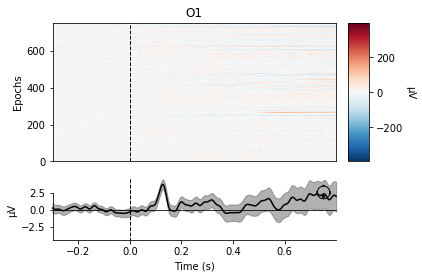

In [8]:
epochs['1'].plot_image(picks=["O1"]);

Loading data for 816 events and 1127 original time points ...
63 bad epochs dropped
753 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


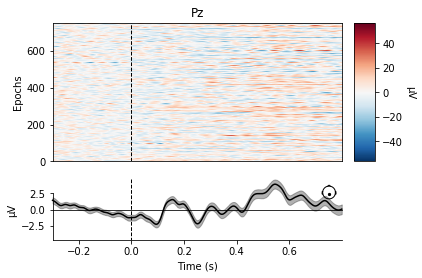

In [9]:
epochs['1'].plot_image(picks=["Pz"]);

More than 6 channels, truncating title ...
Loading data for 816 events and 1127 original time points ...
63 bad epochs dropped
753 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


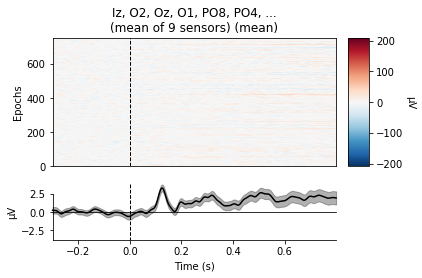

In [10]:
epochs['1'].plot_image(picks=["Iz","O2","Oz","O1", "PO8","PO4","POz","PO3","PO7"],combine="mean");

### looking at the difference between lowest and highest contrast across time and electrodes

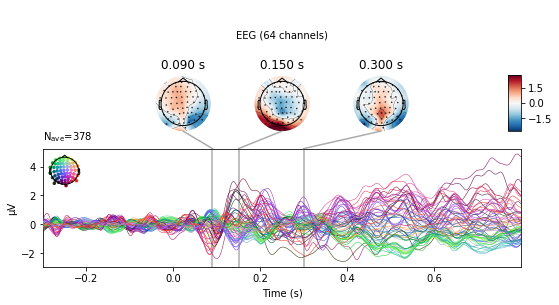

In [13]:
un = epochs["1"].average()
trois = epochs["3"].average()
diff = mne.combine_evoked((un, -trois), weights='equal')
diff.plot_joint(times=[.09,.15,.3]);

### looking at the difference between low and high force across time and electrodes

doesn't make a lot of sense as we should center on EMG/response trigger

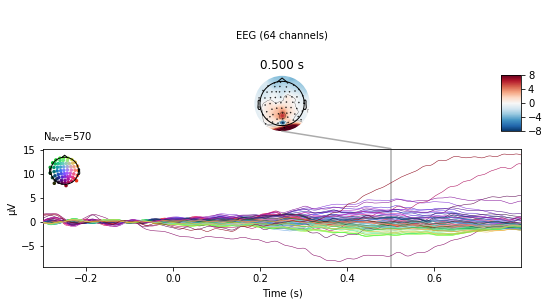

In [14]:
high = epochs["high"].average()
low = epochs["low"].average()
diff = mne.combine_evoked((high, -low), weights='equal')
diff.plot_joint(times=.5);